In [40]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math


def plot_images(images, nrows=1, ncols=5, cmap='gray', figsize=(20, 10), filename=None):
    """
    Plot a list of images using matplotlib subplots.

    Args:
        images (list or np.ndarray): List or array of images to plot.
        nrows (int): Number of rows in the subplot grid.
        ncols (int): Number of columns in the subplot grid.
        cmap (str): Color map for the images (e.g., 'gray', 'viridis').
        figsize (tuple): Tuple specifying the overall figure size (width, height).
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Iterate through all the subplots
    for i, ax in enumerate(axes):
        if i < len(images):  # Plot if there are images left
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axes
        else:  # Turn off any extra axes (used when images < nrows*ncols)
            ax.axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


def show_reconstructions_code(model, images, shape, n_images=5, **kwargs):
    code = model.layers[0].predict(images[:n_images])
    code_images = code.reshape([n_images] + list(shape))
    reconstructed_images = model.layers[1].predict(code)
    # all_images = np.append(images, reconstructed_images, axis=0)
    all_images = [x for x in images[:n_images]]
    all_images.extend(code_images)
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=3, **kwargs)


def show_code_reconstructions(decoder, codes, n_images=5, shape=None):
    code_shape = (1, codes.shape[1])
    reconstructions = decoder.predict(codes[:n_images])
    reconstructed_images = reconstructions if shape is None else reconstructions.reshape([n_images] + list(shape))
    all_images = [x.reshape(code_shape) for x in codes]
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=2)


def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

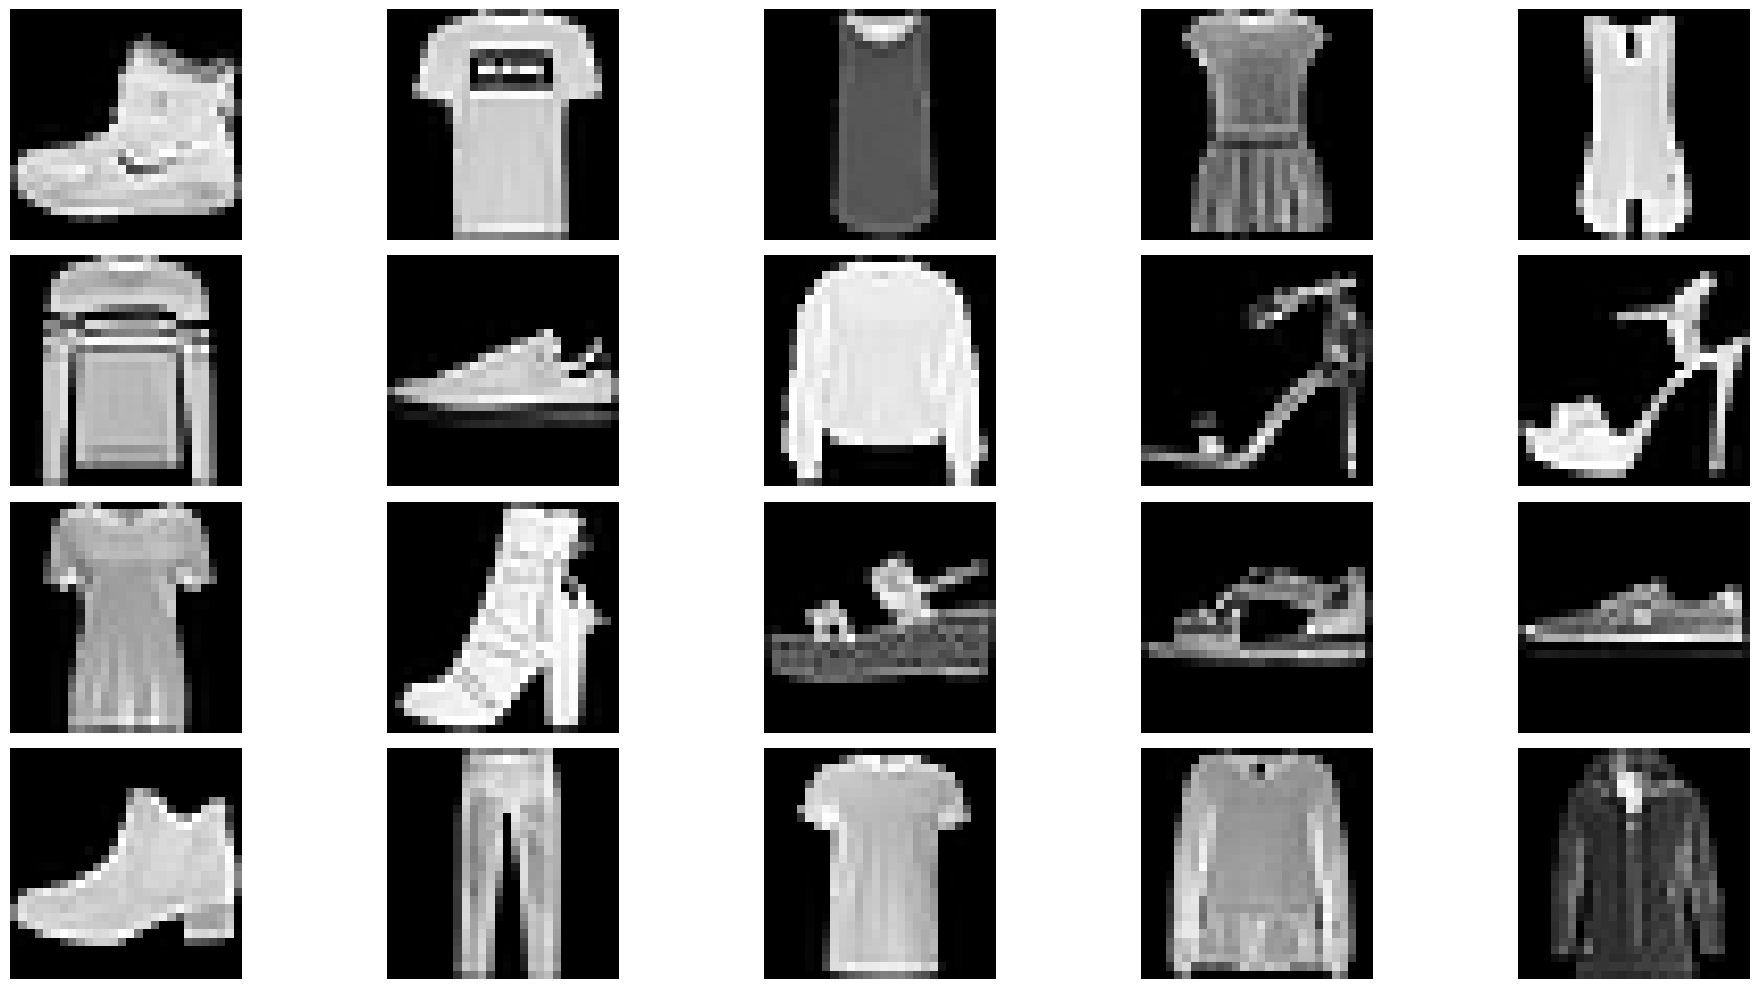

In [41]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

plot_images(X_train[:20], 4, 5)

In [42]:
base_model = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
base_model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    #optimizer="adam"
    metrics=["accuracy"]
)
base_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [43]:
base_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 1s - loss: 0.8292 - accuracy: 0.7876 - val_loss: 0.8100 - val_accuracy: 0.8008 - 1s/epoch - 648us/step
Epoch 2/10
1719/1719 - 1s - loss: 0.8016 - accuracy: 0.8108 - val_loss: 0.9565 - val_accuracy: 0.7930 - 836ms/epoch - 486us/step
Epoch 3/10
1719/1719 - 1s - loss: 0.8094 - accuracy: 0.8158 - val_loss: 1.2335 - val_accuracy: 0.7514 - 741ms/epoch - 431us/step
Epoch 4/10
1719/1719 - 1s - loss: 0.8133 - accuracy: 0.8179 - val_loss: 0.6543 - val_accuracy: 0.8370 - 1s/epoch - 589us/step
Epoch 5/10
1719/1719 - 1s - loss: 0.8064 - accuracy: 0.8212 - val_loss: 0.7984 - val_accuracy: 0.8246 - 809ms/epoch - 471us/step
Epoch 6/10
1719/1719 - 1s - loss: 0.8112 - accuracy: 0.8219 - val_loss: 1.1542 - val_accuracy: 0.7998 - 665ms/epoch - 387us/step
Epoch 7/10
1719/1719 - 1s - loss: 0.8060 - accuracy: 0.8223 - val_loss: 1.1617 - val_accuracy: 0.7880 - 844ms/epoch - 491us/step
Epoch 8/10
1719/1719 - 1s - loss: 0.8279 - accuracy: 0.8217 - val_loss: 1.0899 - val_accuracy: 0.8010 -

In [44]:
base_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 257us/step - loss: 0.9190 - accuracy: 0.8195


[0.9190069437026978, 0.8195000290870667]

In [45]:
model1 = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(5, activation="relu", name="hidden_layer"),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model1.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    # optimizer="adam",
    metrics=["accuracy"]
)
model1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 5)                 3925      
                                                                 
 output_layer (Dense)        (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [46]:
model1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 1s - loss: 1.5715 - accuracy: 0.3096 - val_loss: 1.4783 - val_accuracy: 0.3480 - 1s/epoch - 586us/step
Epoch 2/10
1719/1719 - 1s - loss: 1.4599 - accuracy: 0.3531 - val_loss: 1.4247 - val_accuracy: 0.3756 - 946ms/epoch - 551us/step
Epoch 3/10
1719/1719 - 1s - loss: 1.4320 - accuracy: 0.3713 - val_loss: 1.4209 - val_accuracy: 0.3742 - 1s/epoch - 600us/step
Epoch 4/10
1719/1719 - 1s - loss: 1.4204 - accuracy: 0.3743 - val_loss: 1.4178 - val_accuracy: 0.3842 - 1s/epoch - 763us/step
Epoch 5/10
1719/1719 - 1s - loss: 1.4084 - accuracy: 0.3817 - val_loss: 1.3987 - val_accuracy: 0.3814 - 1s/epoch - 610us/step
Epoch 6/10
1719/1719 - 1s - loss: 1.4030 - accuracy: 0.3856 - val_loss: 1.3940 - val_accuracy: 0.3962 - 1s/epoch - 718us/step
Epoch 7/10
1719/1719 - 1s - loss: 1.3973 - accuracy: 0.3894 - val_loss: 1.4640 - val_accuracy: 0.3424 - 1s/epoch - 658us/step
Epoch 8/10
1719/1719 - 1s - loss: 1.3936 - accuracy: 0.3869 - val_loss: 1.3885 - val_accuracy: 0.3940 - 857ms/epoch

In [47]:
model2 = keras.Sequential(
    [
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="selu", name="hidden_layer"),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.02)
model2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 64)                50240     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [48]:
model2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2, batch_size=32)

Epoch 1/10
1719/1719 - 1s - loss: 0.7145 - accuracy: 0.7723 - val_loss: 0.6062 - val_accuracy: 0.8060 - 1s/epoch - 772us/step
Epoch 2/10
1719/1719 - 1s - loss: 0.6326 - accuracy: 0.8047 - val_loss: 0.6451 - val_accuracy: 0.8012 - 940ms/epoch - 547us/step
Epoch 3/10
1719/1719 - 1s - loss: 0.6362 - accuracy: 0.8071 - val_loss: 0.6048 - val_accuracy: 0.8150 - 1s/epoch - 864us/step
Epoch 4/10
1719/1719 - 1s - loss: 0.6082 - accuracy: 0.8147 - val_loss: 0.7309 - val_accuracy: 0.7794 - 1s/epoch - 652us/step
Epoch 5/10
1719/1719 - 1s - loss: 0.6130 - accuracy: 0.8203 - val_loss: 0.5910 - val_accuracy: 0.8392 - 1s/epoch - 727us/step
Epoch 6/10
1719/1719 - 1s - loss: 0.6199 - accuracy: 0.8214 - val_loss: 0.7281 - val_accuracy: 0.8184 - 1s/epoch - 712us/step
Epoch 7/10
1719/1719 - 1s - loss: 0.5922 - accuracy: 0.8249 - val_loss: 0.6495 - val_accuracy: 0.8146 - 1s/epoch - 642us/step
Epoch 8/10
1719/1719 - 1s - loss: 0.6033 - accuracy: 0.8276 - val_loss: 0.7506 - val_accuracy: 0.7814 - 1s/epoch - 

In [49]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 0s 278us/step - loss: 0.7532 - accuracy: 0.8147


[0.753219485282898, 0.8147000074386597]

# Autoencoder

1/1 [==============================] - 0s 36ms/step


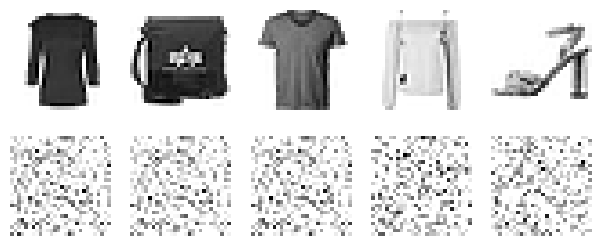

In [50]:
tf.random.set_seed(42) # extra code – ensures reproducibility on CPU

stacked_encoder = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="relu"),
    ]
)
stacked_decoder = keras.Sequential(
    [
        keras.layers.Input(shape=[10]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(28 * 28),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam()
)

plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 3s - loss: 0.8780 - val_loss: 0.7912 - 3s/epoch - 7ms/step
Epoch 2/10
430/430 - 4s - loss: 0.7470 - val_loss: 0.7088 - 4s/epoch - 8ms/step
Epoch 3/10
430/430 - 3s - loss: 0.6972 - val_loss: 0.6887 - 3s/epoch - 8ms/step
Epoch 4/10
430/430 - 3s - loss: 0.6239 - val_loss: 0.6114 - 3s/epoch - 6ms/step
Epoch 5/10
430/430 - 3s - loss: 0.5978 - val_loss: 0.5887 - 3s/epoch - 7ms/step
Epoch 6/10
430/430 - 4s - loss: 0.5854 - val_loss: 0.5793 - 4s/epoch - 8ms/step
Epoch 7/10
430/430 - 3s - loss: 0.5730 - val_loss: 0.5794 - 3s/epoch - 8ms/step
Epoch 8/10
430/430 - 3s - loss: 0.5691 - val_loss: 0.5734 - 3s/epoch - 7ms/step
Epoch 9/10
430/430 - 4s - loss: 0.5711 - val_loss: 0.5937 - 4s/epoch - 8ms/step
Epoch 10/10
430/430 - 3s - loss: 0.5620 - val_loss: 0.5583 - 3s/epoch - 8ms/step
1/1 [==============================] - 0s 8ms/step


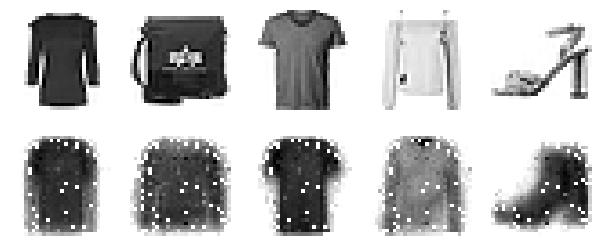

In [51]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
plot_reconstructions(stacked_ae, images=X_valid)

1/1 [==============================] - 0s 35ms/step


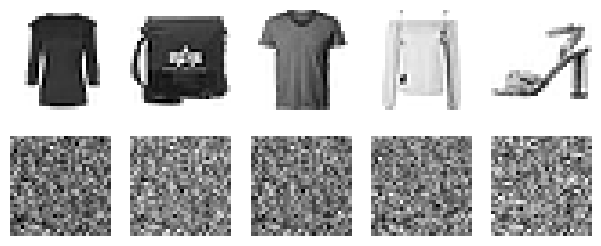

In [52]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

code_size = 9
stacked_encoder = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(14 * 14, activation="selu"),
        keras.layers.Dense(code_size, activation="selu"),
    ]
)
stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Input(shape=[code_size]),
        keras.layers.Dense(196, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
loss = "binary_crossentropy"
stacked_ae.compile(
    loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 5s - loss: 0.3962 - rounded_accuracy: 0.8353 - val_loss: 0.3529 - val_rounded_accuracy: 0.8802 - 5s/epoch - 12ms/step
Epoch 2/10
430/430 - 5s - loss: 0.3335 - rounded_accuracy: 0.8913 - val_loss: 0.3288 - val_rounded_accuracy: 0.8982 - 5s/epoch - 12ms/step
Epoch 3/10
430/430 - 5s - loss: 0.3232 - rounded_accuracy: 0.9000 - val_loss: 0.3233 - val_rounded_accuracy: 0.8977 - 5s/epoch - 12ms/step
Epoch 4/10
430/430 - 5s - loss: 0.3185 - rounded_accuracy: 0.9039 - val_loss: 0.3176 - val_rounded_accuracy: 0.9075 - 5s/epoch - 11ms/step
Epoch 5/10
430/430 - 5s - loss: 0.3154 - rounded_accuracy: 0.9063 - val_loss: 0.3152 - val_rounded_accuracy: 0.9064 - 5s/epoch - 11ms/step
Epoch 6/10
430/430 - 5s - loss: 0.3131 - rounded_accuracy: 0.9083 - val_loss: 0.3126 - val_rounded_accuracy: 0.9100 - 5s/epoch - 12ms/step
Epoch 7/10
430/430 - 5s - loss: 0.3116 - rounded_accuracy: 0.9092 - val_loss: 0.3168 - val_rounded_accuracy: 0.9006 - 5s/epoch - 11ms/step
Epoch 8/10
430/430 - 5s - l

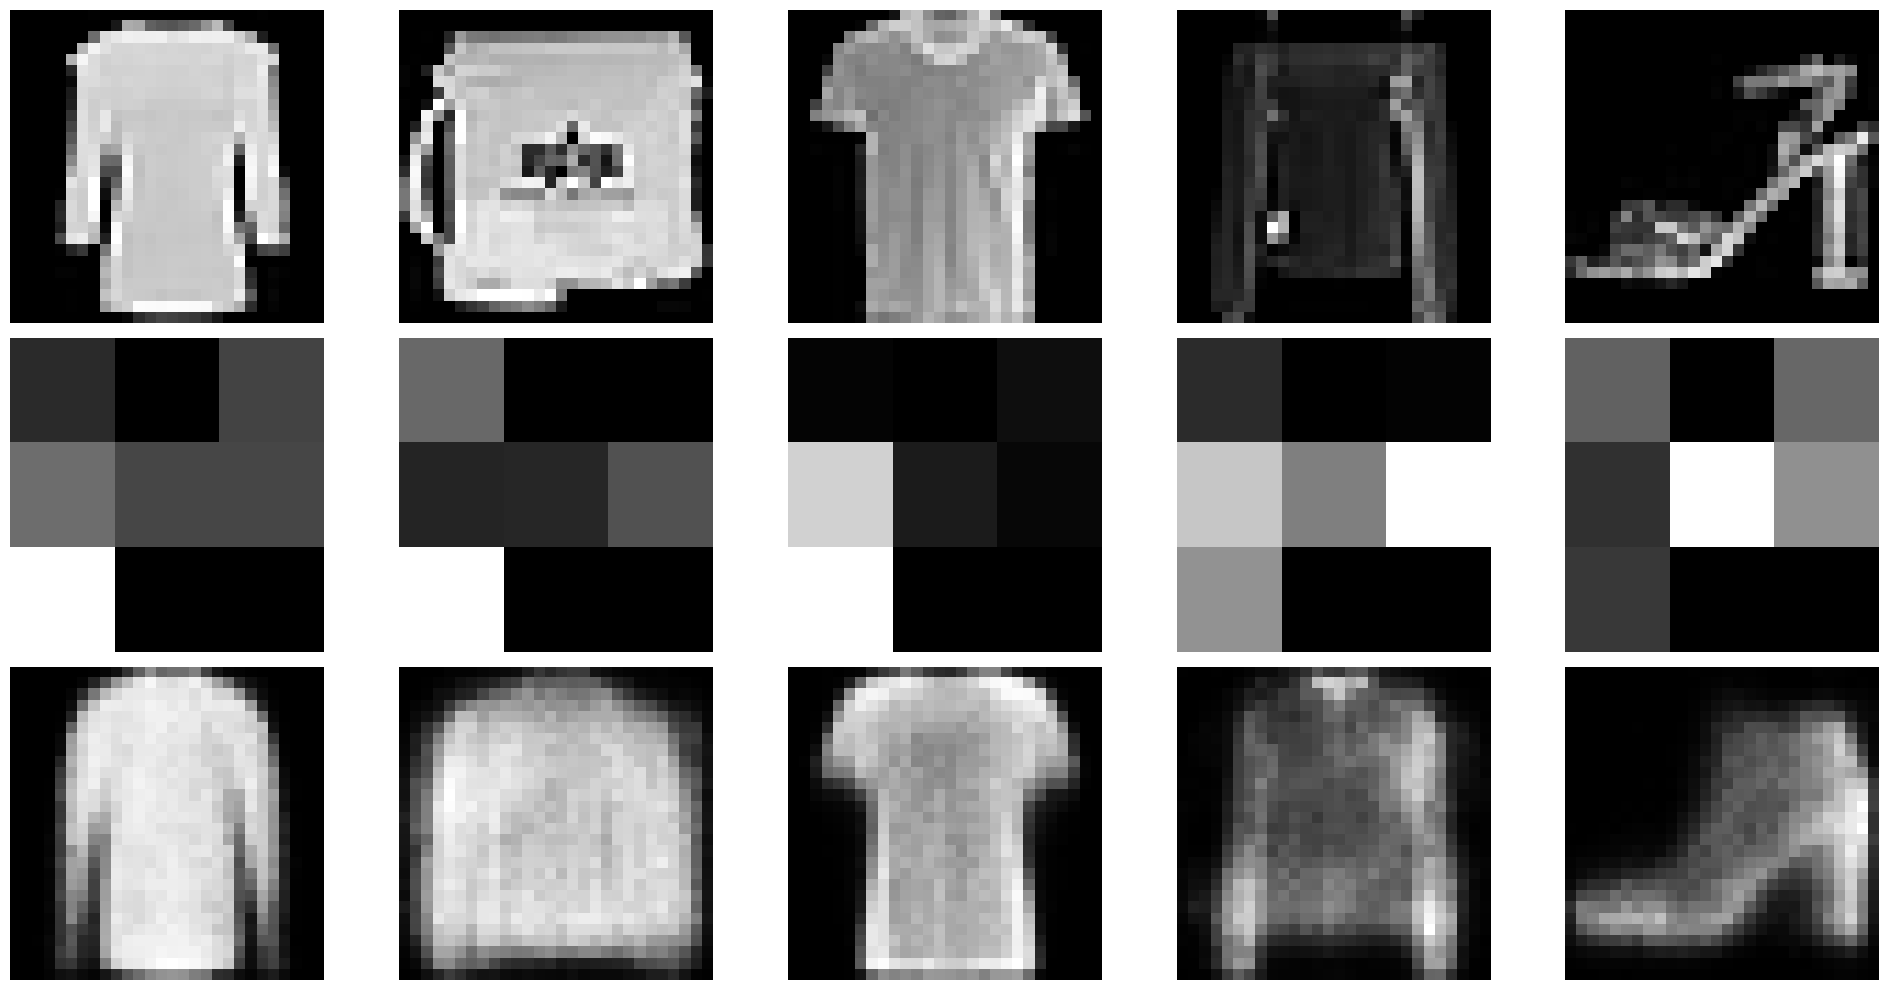

In [53]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(stacked_ae, X_valid, (3, 3), 5)

1/1 [==============================] - 0s 8ms/step


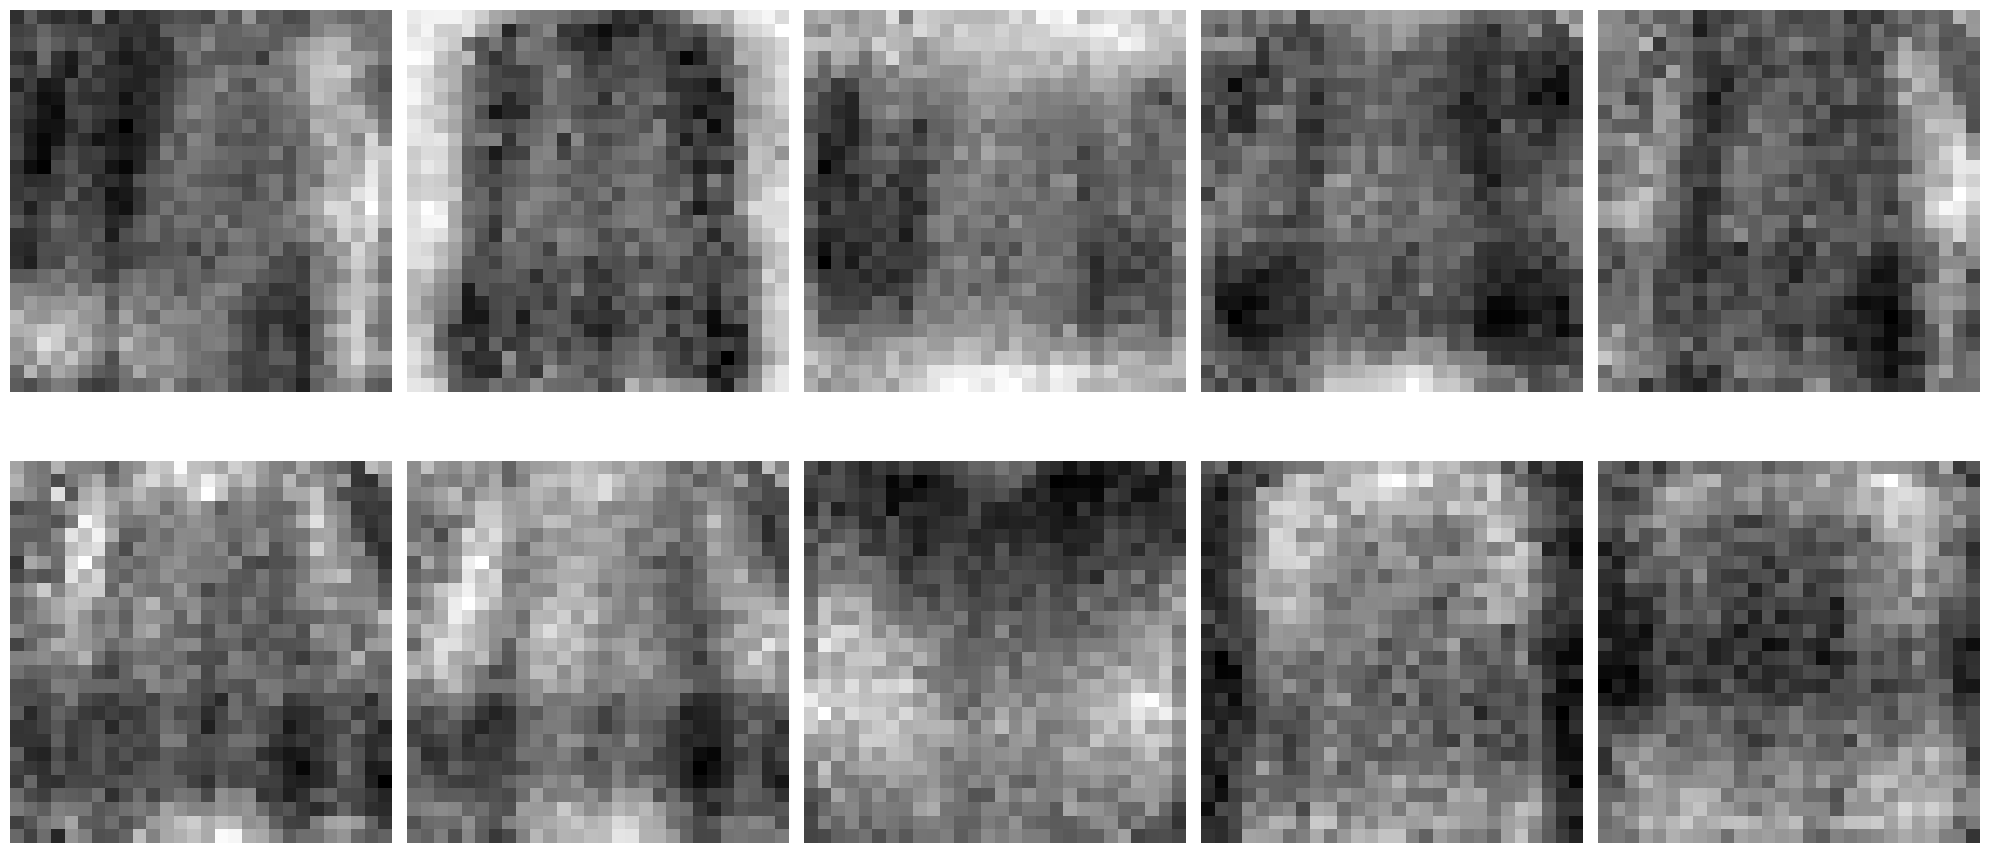

In [54]:
X_code = np.random.normal(size=(10, code_size))
images = stacked_decoder.predict(X_code)
plot_images(images, 2, 5)

1/1 [==============================] - 0s 8ms/step


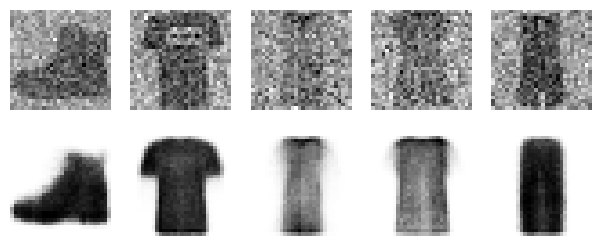

In [55]:
noise = keras.layers.GaussianNoise(0.3)
X_noise = noise(X_train, training=True).numpy()
plot_reconstructions(stacked_ae, images=X_noise[:10])

1/1 [==============================] - 0s 135ms/step


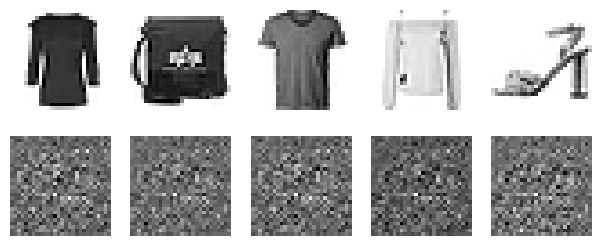

In [56]:
conv_encoder_2 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Reshape([28, 28, 1]),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(code_size)
    ]
)
conv_decoder_2 = keras.models.Sequential(
    [
        keras.layers.Dense(code_size * 64),
        keras.layers.Reshape([3, 3, 64], input_shape=[3 * 3 * 64]),
        keras.layers.Conv2DTranspose(
            32, kernel_size=3, strides=2, padding="VALID", activation="selu", input_shape=[3, 3, 64]
            ),
        keras.layers.Conv2DTranspose(
            16, kernel_size=3, strides=2, padding="SAME", activation="selu"
            ),
        keras.layers.Conv2DTranspose(
            1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"
            ),
        keras.layers.Reshape([28, 28])
    ]
)
conv_ae_2 = keras.models.Sequential([conv_encoder_2, conv_decoder_2])

conv_ae_2.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)

plot_reconstructions(conv_ae_2, images=X_valid)

Epoch 1/10
430/430 - 8s - loss: 0.3815 - rounded_accuracy: 0.8498 - val_loss: 0.3257 - val_rounded_accuracy: 0.8960 - 8s/epoch - 18ms/step
Epoch 2/10
430/430 - 8s - loss: 0.3186 - rounded_accuracy: 0.9024 - val_loss: 0.3128 - val_rounded_accuracy: 0.9106 - 8s/epoch - 18ms/step
Epoch 3/10
430/430 - 8s - loss: 0.3100 - rounded_accuracy: 0.9103 - val_loss: 0.3095 - val_rounded_accuracy: 0.9133 - 8s/epoch - 19ms/step
Epoch 4/10
430/430 - 7s - loss: 0.3064 - rounded_accuracy: 0.9128 - val_loss: 0.3030 - val_rounded_accuracy: 0.9172 - 7s/epoch - 17ms/step
Epoch 5/10
430/430 - 7s - loss: 0.3040 - rounded_accuracy: 0.9145 - val_loss: 0.3067 - val_rounded_accuracy: 0.9127 - 7s/epoch - 16ms/step
Epoch 6/10
430/430 - 7s - loss: 0.3023 - rounded_accuracy: 0.9159 - val_loss: 0.3016 - val_rounded_accuracy: 0.9161 - 7s/epoch - 16ms/step
Epoch 7/10
430/430 - 6s - loss: 0.3009 - rounded_accuracy: 0.9167 - val_loss: 0.3015 - val_rounded_accuracy: 0.9156 - 6s/epoch - 14ms/step
Epoch 8/10
430/430 - 7s - l

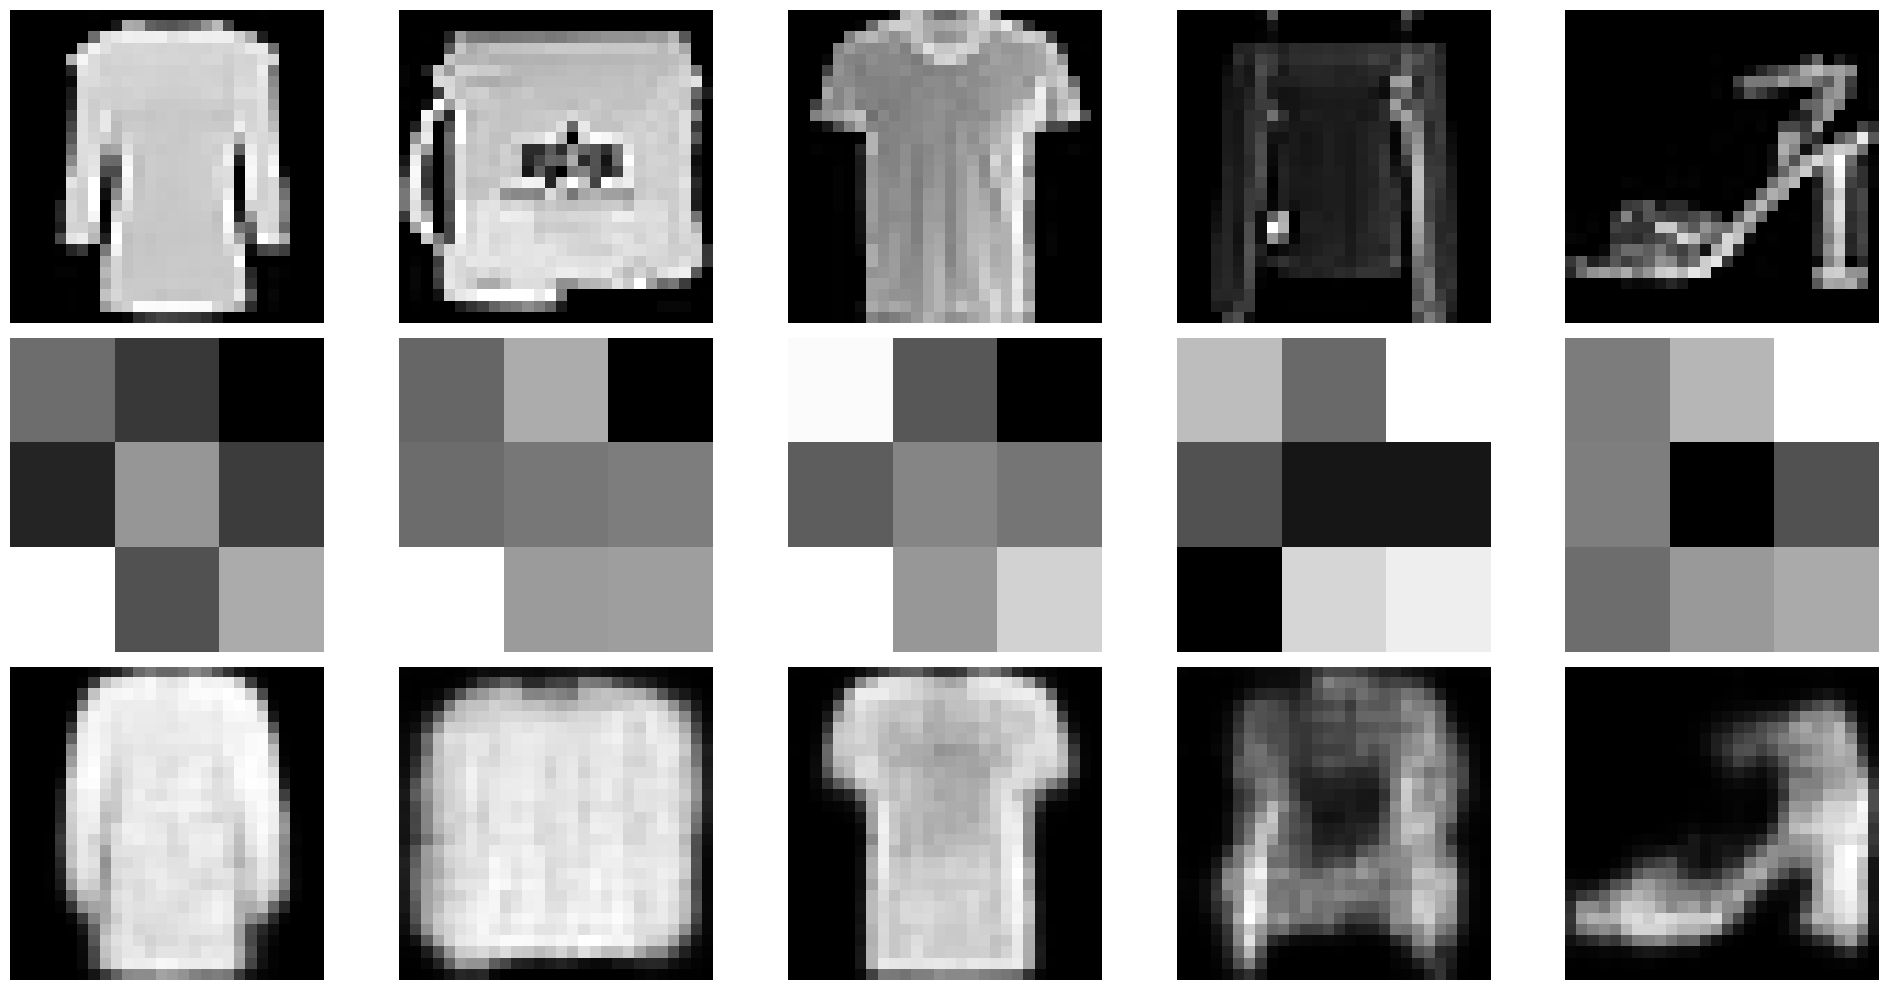

In [57]:
conv_ae_2.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(conv_ae_2, X_valid, (3, 3), 5)

1/1 [==============================] - 0s 35ms/step


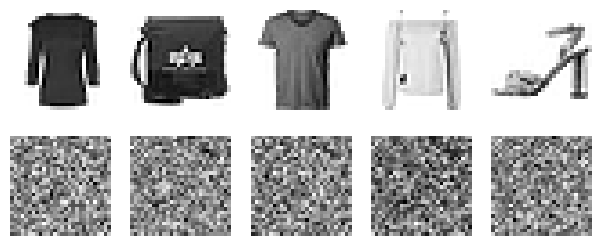

In [58]:
code_size = 64
stacked_encoder1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(14 * 14, activation="selu"),
        keras.layers.Dense(code_size, activation="selu"),
    ]
)
stacked_decoder1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[code_size]),
        keras.layers.Dense(196, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae1 = keras.models.Sequential([stacked_encoder1, stacked_decoder1])
loss = "binary_crossentropy"
stacked_ae1.compile(
    loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5)
)
plot_reconstructions(stacked_ae1, images=X_valid)

Epoch 1/20
430/430 - 4s - loss: 0.3745 - val_loss: 0.3297 - 4s/epoch - 8ms/step
Epoch 2/20
430/430 - 4s - loss: 0.3188 - val_loss: 0.3178 - 4s/epoch - 8ms/step
Epoch 3/20
430/430 - 4s - loss: 0.3096 - val_loss: 0.3079 - 4s/epoch - 9ms/step
Epoch 4/20
430/430 - 4s - loss: 0.3042 - val_loss: 0.3035 - 4s/epoch - 8ms/step
Epoch 5/20
430/430 - 5s - loss: 0.3006 - val_loss: 0.2999 - 5s/epoch - 11ms/step
Epoch 6/20
430/430 - 3s - loss: 0.2974 - val_loss: 0.2966 - 3s/epoch - 8ms/step
Epoch 7/20
430/430 - 3s - loss: 0.2947 - val_loss: 0.2960 - 3s/epoch - 8ms/step
Epoch 8/20
430/430 - 4s - loss: 0.2924 - val_loss: 0.2959 - 4s/epoch - 9ms/step
Epoch 9/20
430/430 - 3s - loss: 0.2905 - val_loss: 0.2912 - 3s/epoch - 8ms/step
Epoch 10/20
430/430 - 4s - loss: 0.2886 - val_loss: 0.2901 - 4s/epoch - 9ms/step
Epoch 11/20
430/430 - 3s - loss: 0.2872 - val_loss: 0.2877 - 3s/epoch - 7ms/step
Epoch 12/20
430/430 - 4s - loss: 0.2860 - val_loss: 0.2875 - 4s/epoch - 9ms/step
Epoch 13/20
430/430 - 4s - loss: 0.2

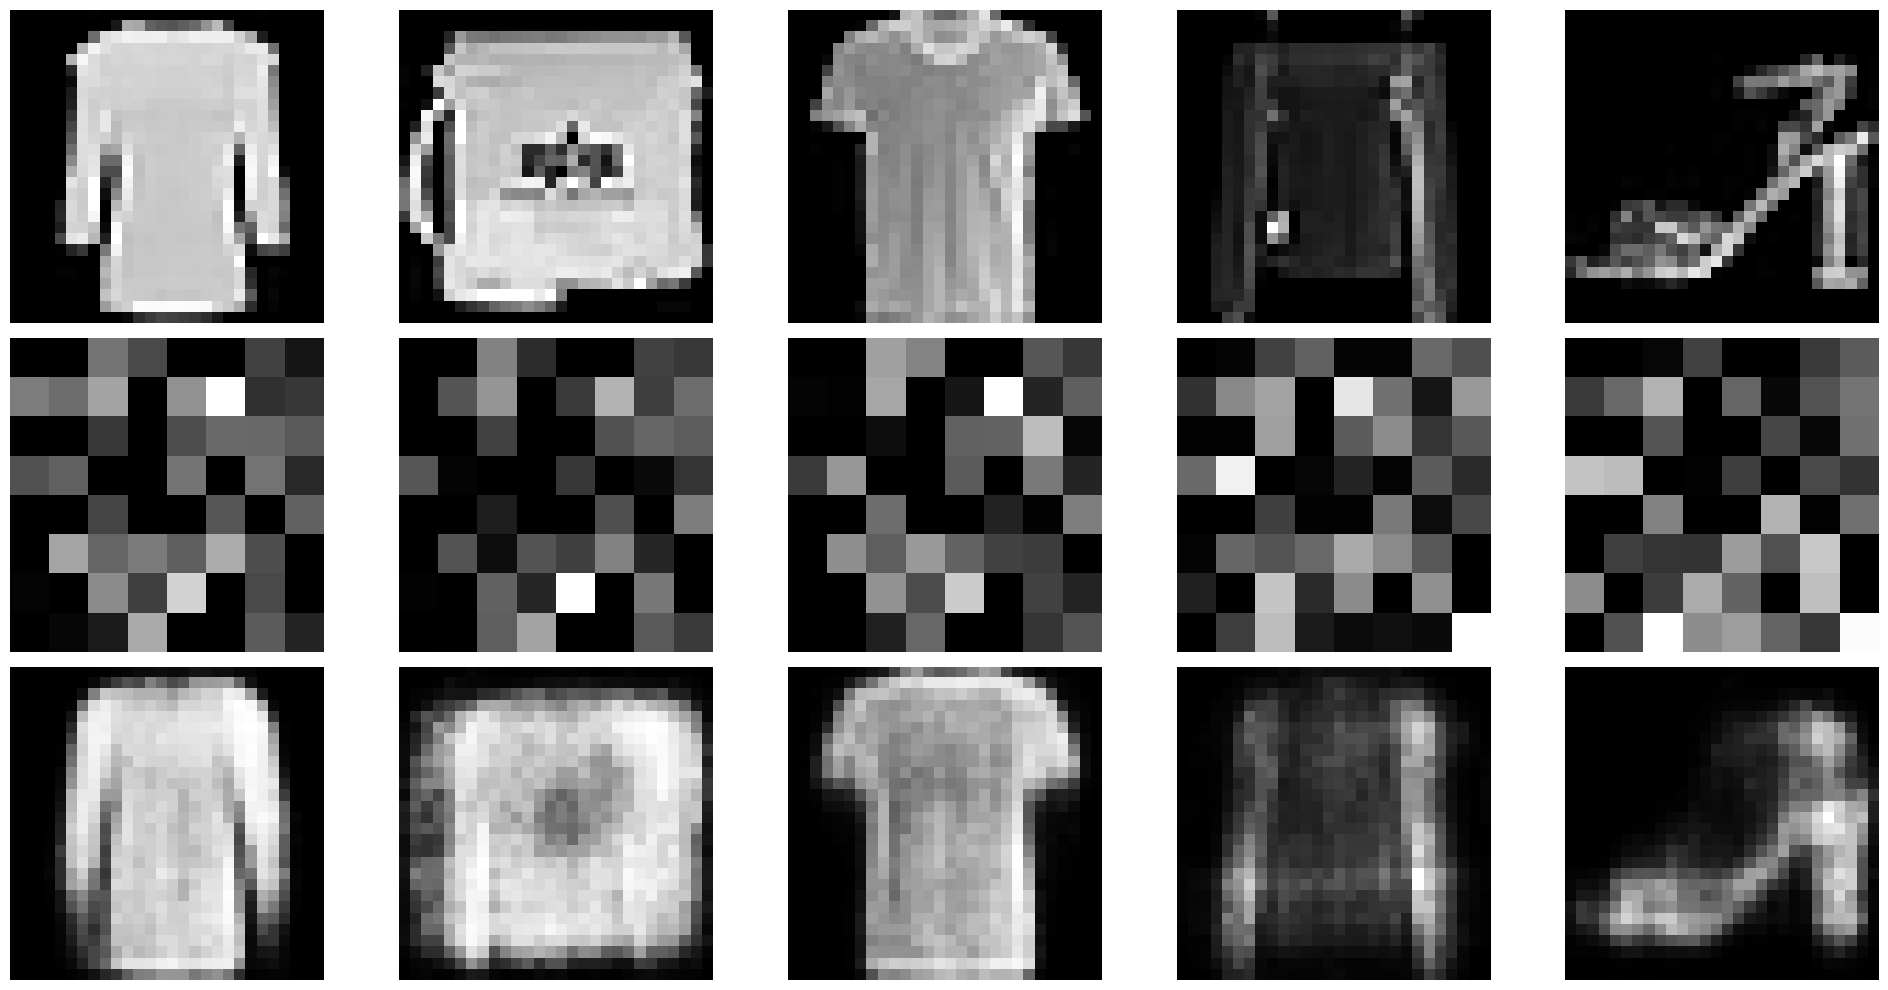

In [59]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.002,
    patience=2,
    mode="auto",
    verbose=True,
    restore_best_weights=True,
)
stacked_ae1.fit(
    X_train, X_train, epochs=20, validation_data=(X_valid, X_valid), verbose=2, batch_size=128, callbacks=[early_stopping]
)
show_reconstructions_code(stacked_ae1, X_valid, (8, 8), 5)


In [60]:
stacked_ae1.save("stacked_ae1.keras")

In [61]:
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = tf.keras.datasets.mnist.load_data()
X_train_digits = tf.cast(mnist_images / 255, tf.float32)
y_train_digits = tf.cast(mnist_labels, tf.int64)

In [62]:

ds = tf.data.Dataset.from_tensor_slices((X_train_digits, y_train_digits))
for x, y in ds.take(2):
    print(f"x.shape: {x.shape}, y: {y.shape}")

x.shape: (28, 28), y: ()
x.shape: (28, 28), y: ()


2025-04-25 15:19:12.076912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [60000]
	 [[{{node Placeholder/_1}}]]


In [63]:
ds_fashion = tf.data.Dataset.from_tensor_slices((X_train[:10_000], y_train[:10_000]))
ds_negative = ds_fashion.map(lambda x, y: (x, tf.constant(10, tf.int64)))
ds = ds.concatenate(ds_negative)
ds = ds.shuffle(1000).batch(128)

In [64]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(name="input_layer"),
        keras.layers.Dense(20, activation="relu", name="hidden_layer"),
        keras.layers.Dense(11, activation="softmax", name="output"),
    ]
)
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Flatten)       (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 20)                15700     
                                                                 
 output (Dense)              (None, 11)                231       
                                                                 
Total params: 15,931
Trainable params: 15,931
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(ds, epochs=10, verbose=2)

Epoch 1/10


2025-04-25 15:19:12.253860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [60000]
	 [[{{node Placeholder/_1}}]]


547/547 - 1s - loss: 0.6208 - accuracy: 0.8400 - 533ms/epoch - 974us/step
Epoch 2/10
547/547 - 0s - loss: 0.3368 - accuracy: 0.9059 - 460ms/epoch - 841us/step
Epoch 3/10
547/547 - 0s - loss: 0.2414 - accuracy: 0.9326 - 314ms/epoch - 574us/step
Epoch 4/10
547/547 - 0s - loss: 0.2100 - accuracy: 0.9419 - 447ms/epoch - 817us/step
Epoch 5/10
547/547 - 0s - loss: 0.1907 - accuracy: 0.9470 - 326ms/epoch - 596us/step
Epoch 6/10
547/547 - 0s - loss: 0.1747 - accuracy: 0.9513 - 491ms/epoch - 898us/step
Epoch 7/10
547/547 - 0s - loss: 0.1618 - accuracy: 0.9550 - 315ms/epoch - 577us/step
Epoch 8/10
547/547 - 0s - loss: 0.1510 - accuracy: 0.9575 - 293ms/epoch - 536us/step
Epoch 9/10
547/547 - 0s - loss: 0.1418 - accuracy: 0.9595 - 340ms/epoch - 622us/step
Epoch 10/10
547/547 - 0s - loss: 0.1340 - accuracy: 0.9619 - 282ms/epoch - 516us/step


In [66]:
model.predict(X_valid[:10])

1/1 [==============================] - 0s 18ms/step


array([[2.77564054e-23, 4.68667159e-32, 1.49182646e-16, 2.53884167e-14,
        5.18096253e-19, 3.52845305e-17, 1.36873071e-17, 3.57071082e-18,
        2.90428963e-15, 2.15447380e-25, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.08110890e-26, 1.61798666e-22,
        2.67471961e-31, 6.91309462e-32, 7.68915292e-37, 3.77388347e-33,
        1.06072695e-26, 0.00000000e+00, 1.00000000e+00],
       [6.80781582e-31, 0.00000000e+00, 7.68194012e-22, 1.79707534e-19,
        6.63359875e-22, 6.42261267e-23, 4.76572517e-25, 2.24056862e-20,
        2.04252057e-21, 9.16531402e-33, 1.00000000e+00],
       [6.15099125e-05, 8.16315890e-07, 6.19178114e-04, 2.18021986e-03,
        8.73198907e-04, 1.76392568e-04, 1.28632411e-04, 1.42583798e-04,
        2.38763590e-04, 2.75225671e-06, 9.95575905e-01],
       [1.95256913e-08, 1.17998684e-11, 8.30921344e-05, 2.65493290e-05,
        6.46291909e-09, 9.97649607e-09, 2.64891842e-09, 5.82886628e-10,
        3.50387324e-07, 9.82185457e-14, 9.99889970e-

In [67]:
model.predict(X_train_digits[10:20])

1/1 [==============================] - 0s 8ms/step


array([[1.27527272e-07, 2.42470433e-05, 1.72714863e-06, 9.99526620e-01,
        4.85360019e-08, 1.24859989e-05, 1.38011727e-10, 2.06996305e-08,
        3.30333482e-04, 1.02051832e-04, 2.29710145e-06],
       [1.51102031e-05, 3.16590117e-03, 7.76923334e-05, 2.78226507e-05,
        2.17651963e-04, 9.94593203e-01, 1.17616901e-05, 5.64193260e-06,
        8.22719187e-04, 1.79901156e-06, 1.06069585e-03],
       [9.04956177e-14, 1.75327219e-08, 2.60941135e-07, 9.99998927e-01,
        2.65111655e-10, 1.70685888e-09, 9.91320775e-15, 3.35963285e-10,
        3.92095190e-10, 1.03386504e-13, 7.63327250e-07],
       [9.86982741e-07, 3.48525191e-07, 2.93149560e-06, 2.43642489e-07,
        3.51141789e-05, 6.69691099e-06, 9.99887466e-01, 4.02150704e-08,
        5.53314603e-05, 4.62576054e-06, 6.26473866e-06],
       [1.83304819e-05, 9.97166932e-01, 6.21046711e-05, 4.66876663e-04,
        2.25831286e-06, 2.34464213e-04, 3.01316497e-04, 6.53084717e-05,
        1.66573469e-03, 2.06910772e-06, 1.46967704e-

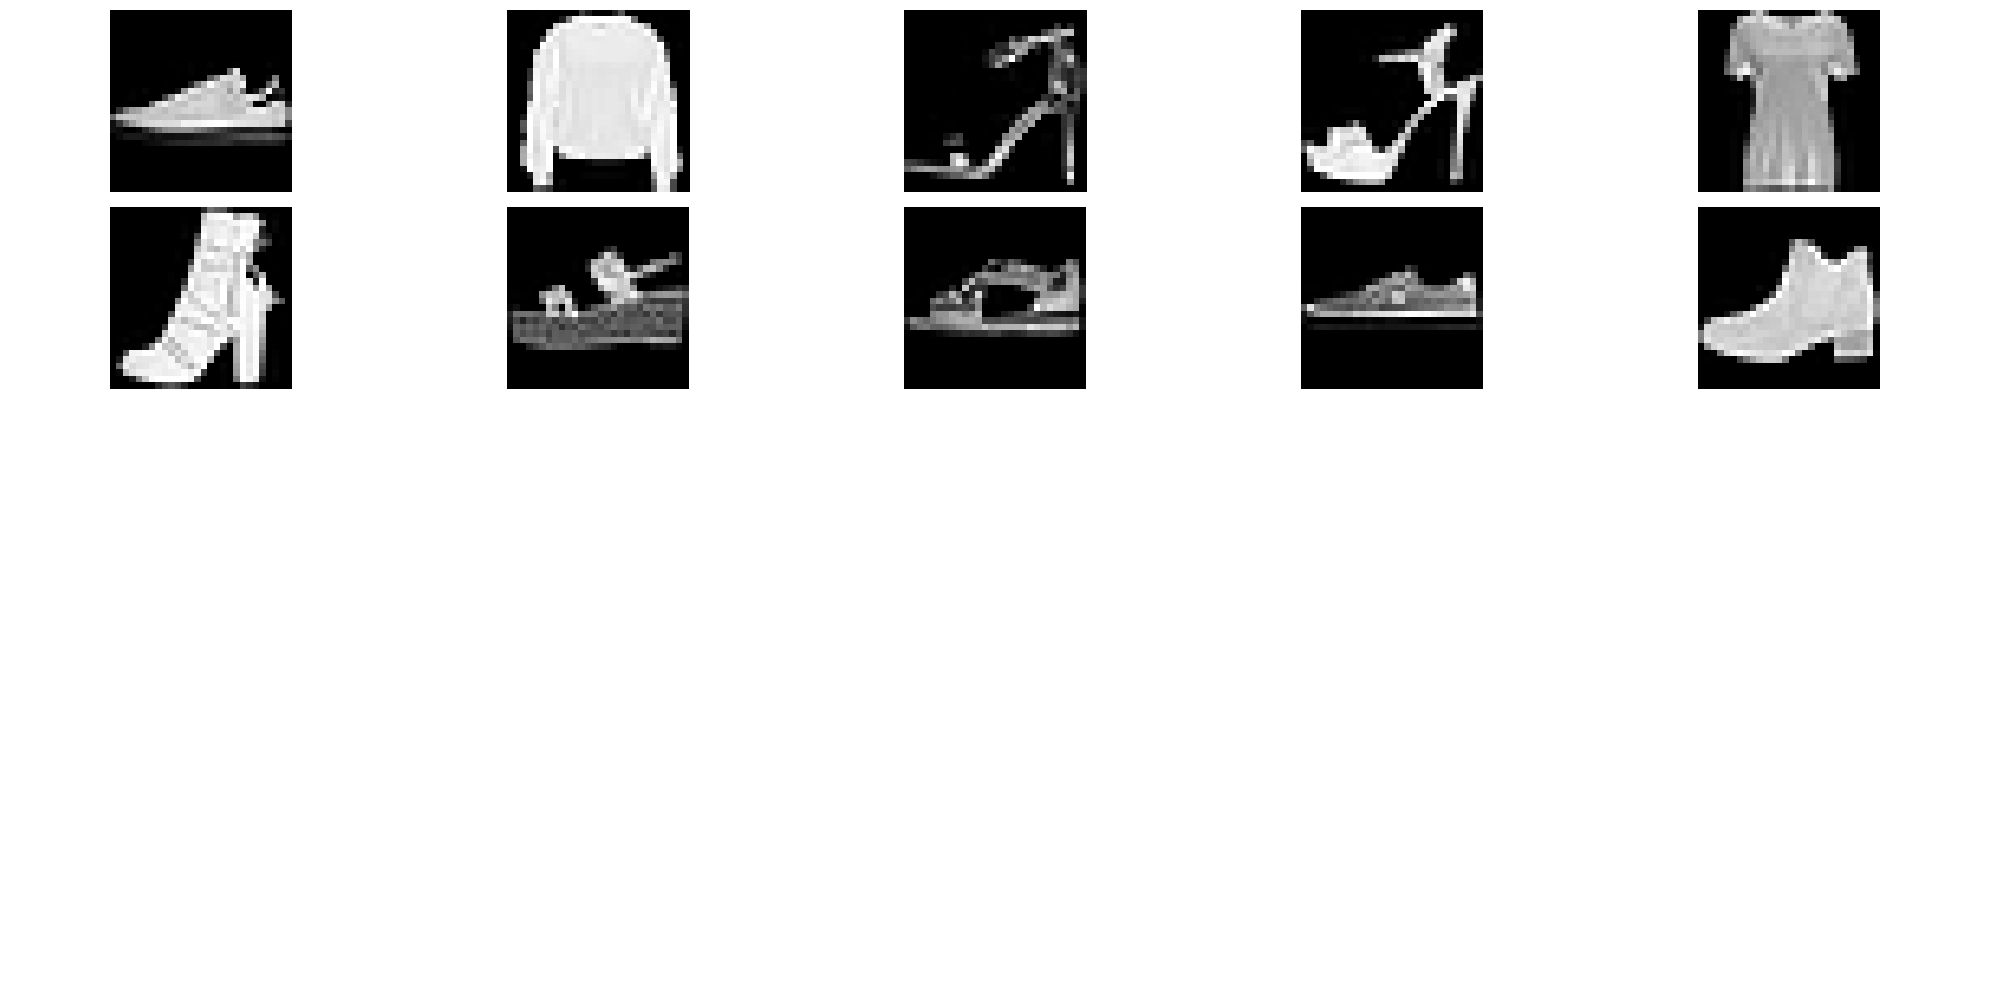

In [68]:
plot_images(X_train[6:16], 5, 5)

In [69]:
from keras.models import load_model

model = load_model("stacked_ae1.keras")

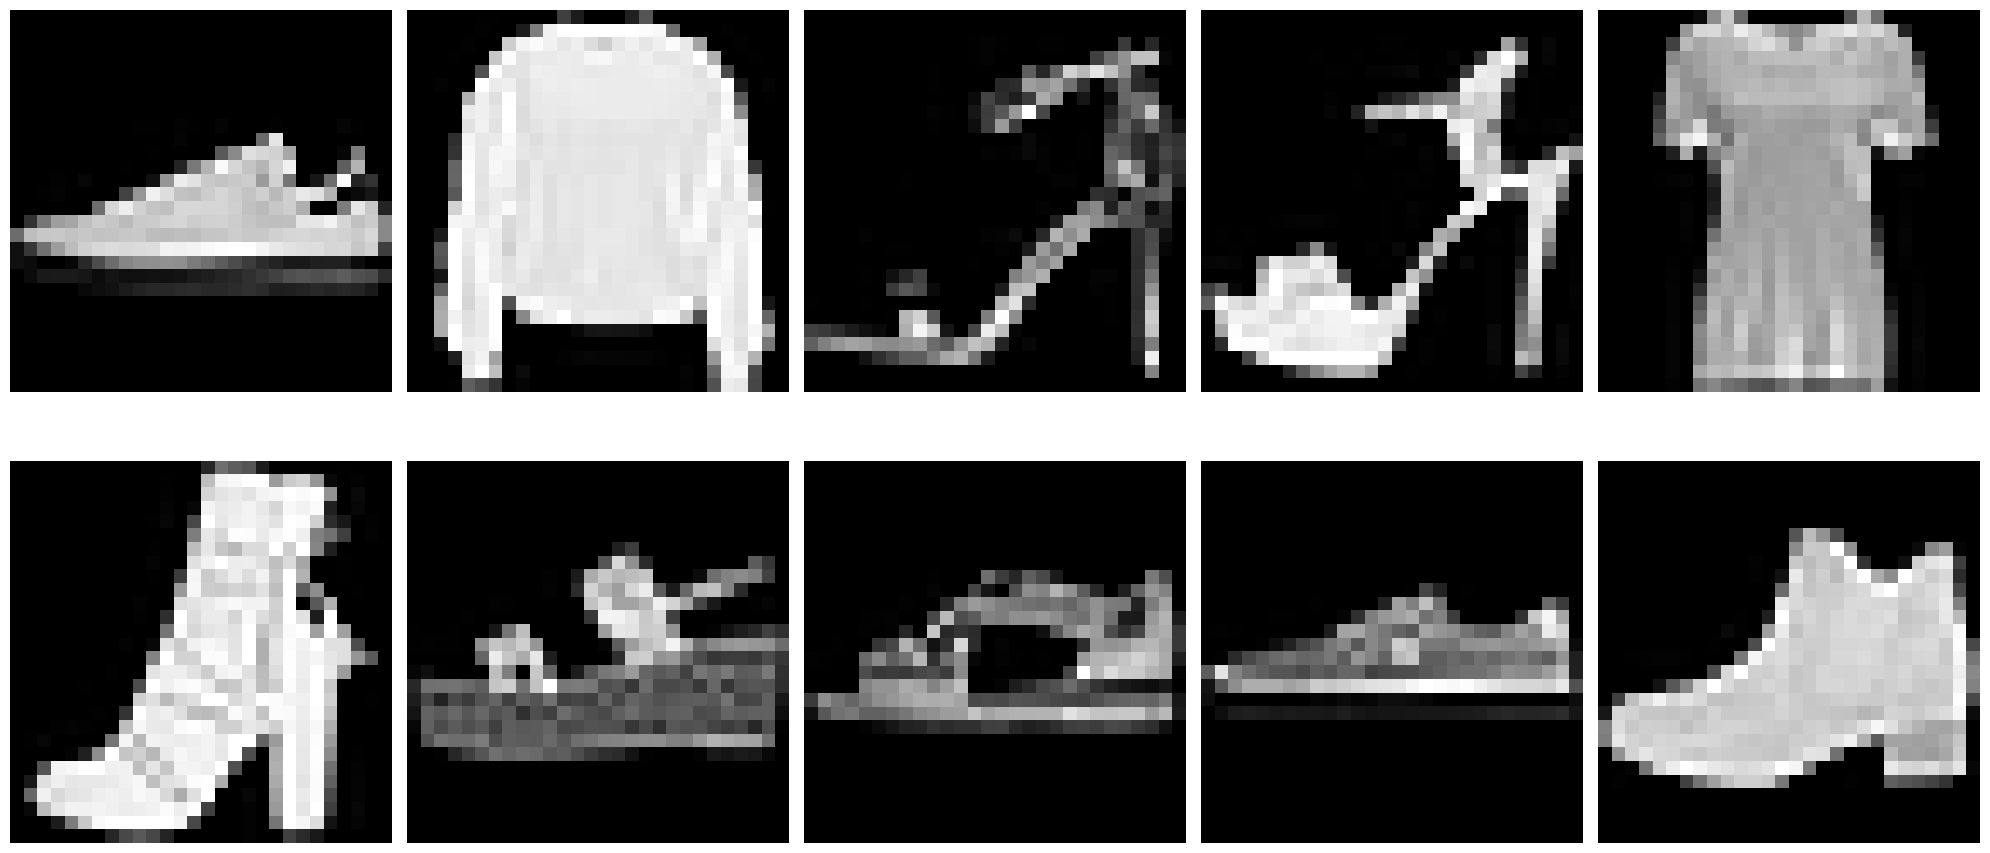

In [70]:
plot_images(X_train[6:16], 2, 5)

1/1 [==============================] - 0s 8ms/step
(10, 64)
(1, 64)
1/1 [==============================] - 0s 8ms/step
(1, 28, 28)


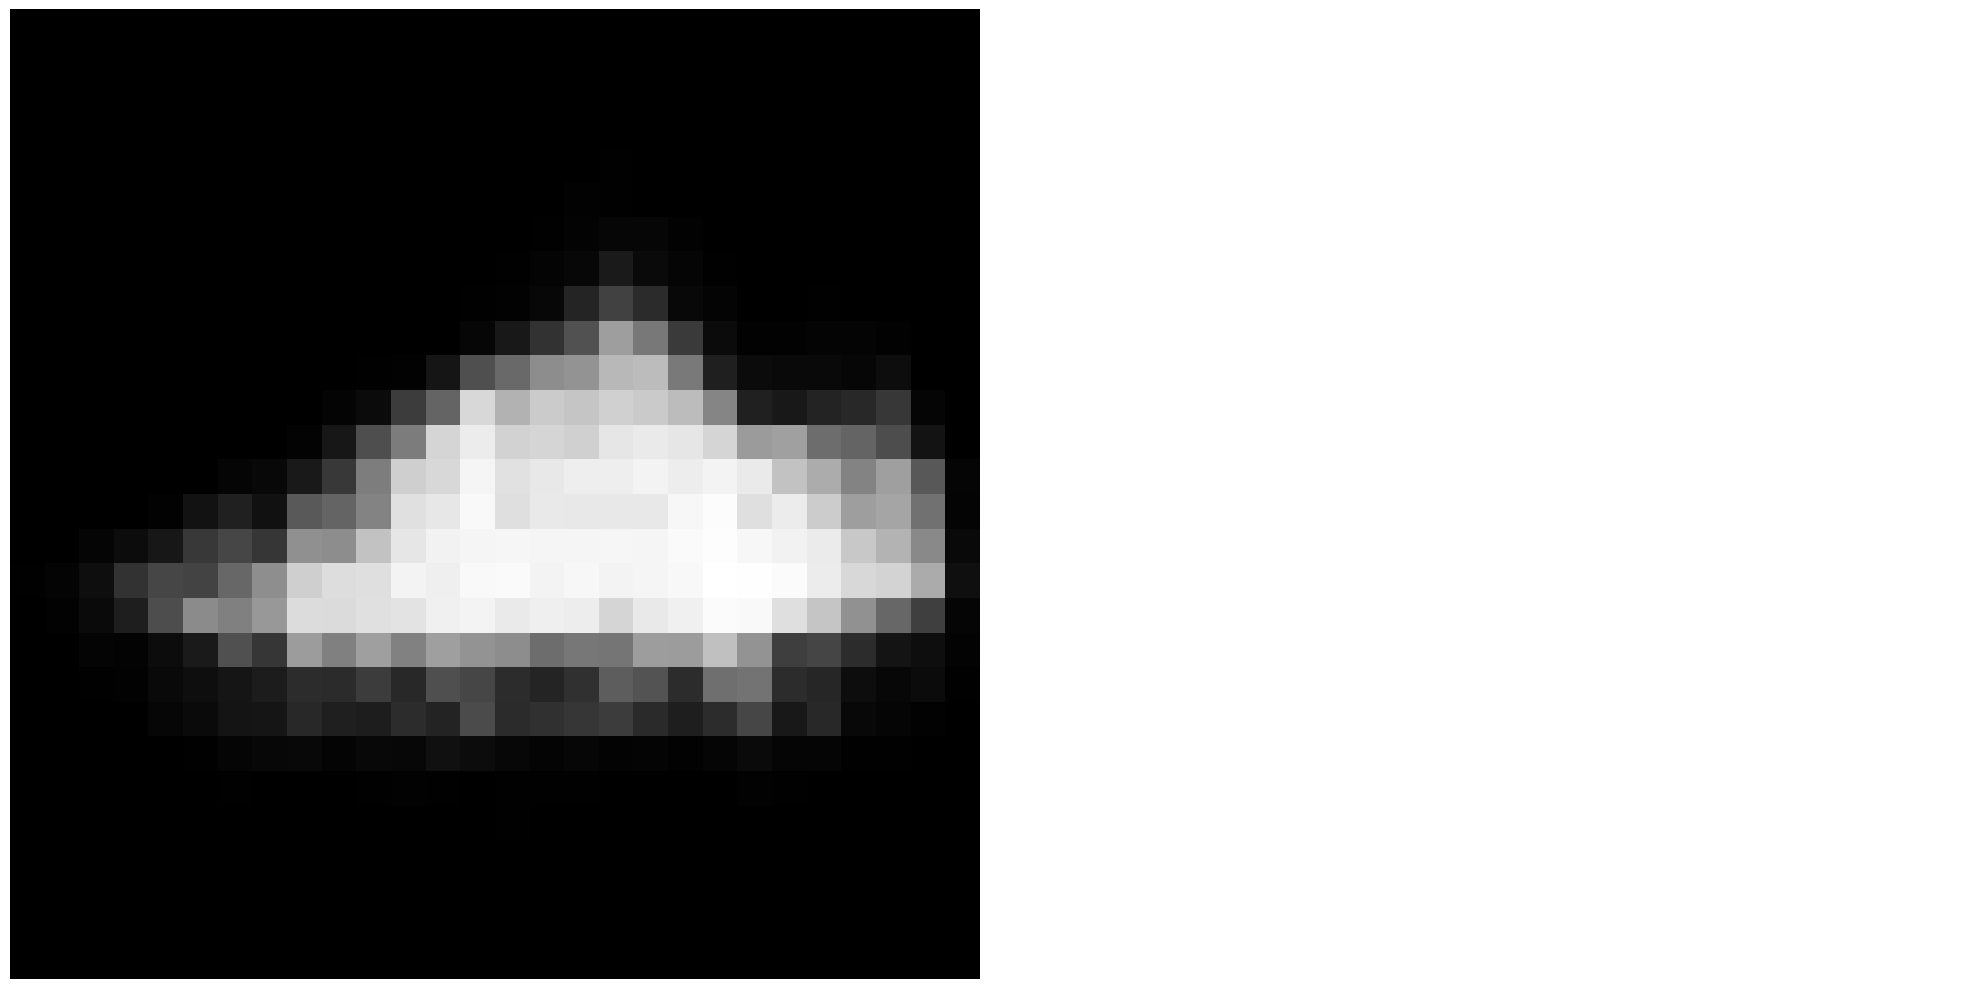

In [73]:
codes = model.layers[0].predict(X_train[6:16])
print(codes.shape)
code = codes[0] + 0.4 * codes[5]
code = code.reshape([1, 64])
print(code.shape)
img = model.layers[1].predict(code)
print(img.shape)
plot_images(img, 1, 2)

In [74]:
A = codes[2]
B = codes[3]
cosine_similarity = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
print(f"Cosine similarity: {cosine_similarity:.5f}")

Cosine similarity: 0.74516
